In [14]:
import requests
import os
import zipfile
import sys

import json
import numpy as np
import pickle

from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F

import tqdm
from tqdm import tqdm_notebook
from IPython.display import clear_output

from torch.utils.data import Dataset, DataLoader

from random import choice

import matplotlib.pyplot as plt
from skimage.transform import resize

---vocabulary---

In [3]:
captions_dict = json.load(open('data/captions_tokenized.json'))
captions = list(captions_dict.values())

In [4]:
# Build a Vocabulary

word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure

for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        for token in sentence:
          word_counts[token] += 1

In [5]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

word_to_index = {w: i for i, w in enumerate(vocab)}

In [6]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#'] # before idx=3 (PAD) are special tokens, after idx=3 - real words

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [7]:
class CaptionNet(nn.Module):
    
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()
        
        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, num_layers = 1,
                            hidden_size = lstm_units, batch_first = True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features = lstm_units, out_features=n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        caption_embedding = self.embedding(captions_ix)

        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hn, cn) = self.lstm.forward(caption_embedding, (initial_cell[None], initial_hid[None]))

        # compute logits from lstm_out
        out = self.logits(lstm_out)
        return out

---network---

In [8]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
network = CaptionNet(n_tokens).to(DEVICE)
network.load_state_dict(torch.load('model.pt', map_location=DEVICE))

<All keys matched successfully>

In [10]:
from beheaded_inception3 import beheaded_inception_v3

try:
  if inception is None:
    inception = beheaded_inception_v3().eval()
except NameError:
    inception = beheaded_inception_v3().eval()

def generate_caption(image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100, non_random=False):
    if non_random:
        np.random.seed(0)

    global network
    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

C:\Anaconda3\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [17]:


# sample image
! wget https://s2.best-wallpaper.net/wallpaper/1600x1200/1311/Orange-black-feathers-bird_1600x1200.jpg -O data/img.jpg --no-check-certificate

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
--2021-05-23 15:34:43--  https://s2.best-wallpaper.net/wallpaper/1600x1200/1311/Orange-black-feathers-bird_1600x1200.jpg
Распознаётся s2.best-wallpaper.net... 148.251.86.66
Устанавливается соединение с s2.best-wallpaper.net|148.251.86.66|:443... соединение установлено.
ПРЕДУПРЕЖДЕНИЕ: невозможно проверить сертификат s2.best-wallpaper.net, запрошенный `/C=US/O=Let's Encrypt/CN=R3':
  Невозможно локально проверить подлинность запрашивающего.
Запрос HTTP послан, ожидается ответ... 200 OK
Длина: 429398 (419K) [image/jpeg]
Сохраняется в каталог: `data/img.jpg'.

     0K .......... .......... .......... .......... .......... 11%  442K 1s
    50K .......... .......... .......... .......... .......... 23%  887K 1s
   100K .......... .......... .......... .......... .......... 35% 11,2M 0s
   150K .......... .......... .......... .......... .......... 47%  911K 0s
   200K .......... .......... ...

a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .
a man in a red shirt be run across a field .


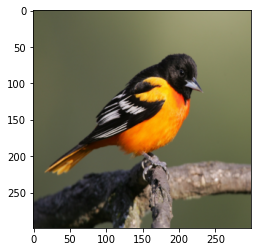

In [27]:
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, t=5., non_random=True))

In [11]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is a dog'.split()
 
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000
Individual 3-gram: 0.500000
Individual 4-gram: 0.000000


C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [12]:
#inception input image size format
TARGET_SIZE = (299,299)

def generate_image_paths():
    for pic in glob.glob('./Flicker8k_Dataset/*.jpg'):
        yield pic
        
def train_image_names():
    with open('text/Flickr_8k.trainImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
        
def test_image_names():
    with open('text/Flickr_8k.testImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
            
def dev_image_names():
    with open('text/Flickr_8k.devImages.txt') as image_names:
        for line in image_names:
            path = f'./Flicker8k_Dataset/{line.strip()}'
            yield path
        
def generate_code(image_path_sequence_generator):
    gen = image_path_sequence_generator
    for path in gen:
        file = load_img(path, target_size=TARGET_SIZE)
        data = asarray(file) / 255
        code = generate_code_inception(data)
        code = code.detach() # detach from computational graph
        yield path, code

In [15]:
dev_captions = json.load(open('data/captions_tokenized.json'))

results = []
for path in dev_image_names():
    #print(path)
    img = plt.imread(path)
    img = resize(img, (299, 299))
    
    pic_name = path.split('/')[-1].split('.')[0]
    ref_captions = dev_captions[pic_name]
    ref_captions = [item[1:-1] for item in ref_captions] #drop #START and #END
    #print(pic_name)
    caption = generate_caption(img, t=5., non_random=True).split()
    print(caption)
    #print(ref_captions)
    
    print('Individual 1-gram: %f' % sentence_bleu(ref_captions, caption, weights=(1, 0, 0, 0, 0)))
    print('Individual 2-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 1, 0, 0, 0)))
    print('Individual 3-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 1, 0, 0)))
    print('Individual 4-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 0, 1, 0)))
    print('Individual 5-gram: %f' % sentence_bleu(ref_captions, caption, weights=(0, 0, 0, 0, 1)))
    
    res = sentence_bleu(ref_captions, caption, weights=(1, 0, 0, 0, 0))
    results.append(res)
    print('Total: %f' % res)

['a', 'man', 'be', 'sit', 'on', 'a', 'curb', 'in', 'front', 'of', 'a', 'pool', '.']
Individual 1-gram: 0.461538
Individual 2-gram: 0.083333
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.461538


C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 5-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['a', 'man', 'be', 'climb', 'a', 'rock', 'wall', 'with', 'a', 'view', 'of', 'his', 'or', 'her', 'hand', '.']
Individual 1-gram: 0.375000
Individual 2-gram: 0.066667
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.375000
['a', 'dog', 'with', 'a', 'muzzle', 'be', 'run', 'on', 'the', 'grass', '.']
Individual 1-gram: 0.727273
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.727273
['a', 'dog', 'be', 'run', 'through', 'a', 'field', 'with', 'a', 'flower', 'in', 'the', 'background', '.']
Individual 1-gram: 0.642857
Individual 2-gram: 0.307692
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.642857
['a', 'woman', 'in', 'a', 'bikini', 'be', 'stand', 'on', 'the', 'sand', 'at', 'a', 'beach', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.076923
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Tota

C:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


['a', 'man', 'be', 'do', 'a', 'trick', 'on', 'a', 'bike', 'in', 'the', 'air', '.']
Individual 1-gram: 0.783506
Individual 2-gram: 0.385817
Individual 3-gram: 0.084178
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.783506
['a', 'girl', 'play', 'a', 'hula', 'hoop', '.']
Individual 1-gram: 0.619198
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.619198
['a', 'girl', 'in', 'a', 'pink', 'hat', 'be', 'smile', 'and', 'smile', '.']
Individual 1-gram: 0.545455
Individual 2-gram: 0.300000
Individual 3-gram: 0.222222
Individual 4-gram: 0.125000
Individual 5-gram: 0.000000
Total: 0.545455
['a', 'black', 'and', 'white', 'dog', 'be', 'swim', 'in', 'the', 'water', '.']
Individual 1-gram: 1.000000
Individual 2-gram: 0.800000
Individual 3-gram: 0.555556
Individual 4-gram: 0.375000
Individual 5-gram: 0.142857
Total: 1.000000
['a', 'man', 'be', 'walk', 'through', 'a', 'rocky', 'area', 'with', 'a', 'mountain', 'in',

['a', 'dog', 'run', 'on', 'a', 'grassy', 'field', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.428571
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.750000
['a', 'crowd', 'of', 'person', 'pose', 'together', 'and', 'pose', 'for', 'a', 'picture', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.090909
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.583333
['a', 'black', 'dog', 'run', 'through', 'a', 'field', '.']
Individual 1-gram: 0.601378
Individual 2-gram: 0.392737
Individual 3-gram: 0.343645
Individual 4-gram: 0.274916
Individual 5-gram: 0.171822
Total: 0.601378
['a', 'boy', 'wear', 'a', 'blue', 'shirt', 'be', 'stand', 'with', 'a', 'camera', 'up', 'in', 'the', 'background', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.066667
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'young', 'girl', 'be', 'run', 'with', 'a', 

['a', 'person', 'in', 'a', 'red', 'jacket', 'and', 'black', 'pants', 'be', 'ski', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.181818
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.583333
['a', 'dog', 'with', 'a', 'red', 'collar', 'be', 'swim', 'in', 'the', 'water', '.']
Individual 1-gram: 0.916667
Individual 2-gram: 0.727273
Individual 3-gram: 0.600000
Individual 4-gram: 0.444444
Individual 5-gram: 0.250000
Total: 0.916667
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'jean', 'run', 'down', 'a', 'track', '.']
Individual 1-gram: 0.461538
Individual 2-gram: 0.166667
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.461538
['a', 'black', 'and', 'brown', 'dog', 'run', 'through', 'a', 'field', 'of', 'grass', 'and', 'flower', '.']
Individual 1-gram: 0.642857
Individual 2-gram: 0.230769
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.642857
['a', '

['a', 'boy', 'play', 'soccer', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.600000
['a', 'dog', 'play', 'in', 'the', 'snow', '.']
Individual 1-gram: 0.644123
Individual 2-gram: 0.500985
Individual 3-gram: 0.300591
Individual 4-gram: 0.187869
Individual 5-gram: 0.000000
Total: 0.644123
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'hat', 'be', 'hold', 'a', 'newspaper', '.']
Individual 1-gram: 0.461538
Individual 2-gram: 0.083333
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.461538
['a', 'man', 'on', 'a', 'motorcycle', 'ride', 'a', 'dirt', 'bike', 'in', 'the', 'dirt', '.']
Individual 1-gram: 0.846154
Individual 2-gram: 0.583333
Individual 3-gram: 0.363636
Individual 4-gram: 0.200000
Individual 5-gram: 0.111111
Total: 0.846154
['a', 'woman', 'in', 'a', 'red', 'jacket', 'and', 'hat', 'walk', 'down', 'a', 'street', '.']
Individual 1-g

['a', 'man', 'in', 'a', 'blue', 'shirt', 'be', 'hold', 'a', 'baby', 'with', 'a', '#UNK#', '.']
Individual 1-gram: 0.857143
Individual 2-gram: 0.307692
Individual 3-gram: 0.166667
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.857143
['a', 'dog', 'be', 'run', 'on', 'a', 'beach', '.']
Individual 1-gram: 0.584101
Individual 2-gram: 0.111257
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.584101
['a', 'man', 'in', 'a', 'green', 'shirt', 'be', 'stand', 'next', 'to', 'a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'hat', '.']
Individual 1-gram: 0.368421
Individual 2-gram: 0.055556
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.368421
['a', 'hiker', 'with', 'a', 'backpack', 'be', 'walk', 'through', 'a', 'snowy', 'mountain', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.272727
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.583333
['a',

['a', 'black', 'dog', 'with', 'a', 'black', 'collar', 'be', 'lay', 'on', 'a', 'red', 'carpet', '.']
Individual 1-gram: 0.428571
Individual 2-gram: 0.076923
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.428571
['a', 'group', 'of', 'person', 'be', 'line', 'up', 'in', 'their', 'village', '.']
Individual 1-gram: 0.636364
Individual 2-gram: 0.300000
Individual 3-gram: 0.111111
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.636364
['a', 'black', 'dog', 'be', 'run', 'through', 'a', 'field', '.']
Individual 1-gram: 0.636917
Individual 2-gram: 0.447832
Individual 3-gram: 0.307085
Individual 4-gram: 0.119422
Individual 5-gram: 0.000000
Total: 0.636917
['a', 'person', 'on', 'a', 'bike', 'be', 'jump', 'over', 'a', 'hill', '.']
Individual 1-gram: 0.545455
Individual 2-gram: 0.100000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.545455
['a', 'man', 'on', 'a', 'bmx', 'bike', 'jump', 'up', '

['two', 'man', 'in', 'a', 'boat', 'paddle', 'down', 'a', 'river', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.222222
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.600000
['a', 'group', 'of', 'girl', 'be', 'stand', 'in', 'front', 'of', 'a', 'bus', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.272727
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.583333
['two', 'dog', 'play', 'with', 'a', 'ball', 'in', 'the', 'grass', '.']
Individual 1-gram: 1.000000
Individual 2-gram: 0.444444
Individual 3-gram: 0.250000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
Total: 1.000000
['a', 'football', 'player', 'be', 'tackle', 'another', 'player', 'who', 'have', 'the', 'ball', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.454545
Individual 3-gram: 0.300000
Individual 4-gram: 0.222222
Individual 5-gram: 0.125000
Total: 0.750000
['a', 'baby', 'in', 'a', 'blue', 'shirt', 'be', 'hol

['a', 'little', 'girl', 'in', 'a', 'pink', 'shirt', 'be', 'swing', 'on', 'a', 'playground', '.']
Individual 1-gram: 0.527633
Individual 2-gram: 0.285801
Individual 3-gram: 0.155892
Individual 4-gram: 0.085740
Individual 5-gram: 0.000000
Total: 0.527633
['a', 'young', 'boy', 'in', 'a', 'blue', 'jacket', 'be', 'hold', 'a', 'newspaper', '.']
Individual 1-gram: 0.833333
Individual 2-gram: 0.272727
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.833333
['a', 'boy', 'do', 'a', 'trick', 'on', 'a', 'bicycle', '.']
Individual 1-gram: 0.795413
Individual 2-gram: 0.447420
Individual 3-gram: 0.255668
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.795413
['a', 'man', 'and', 'a', 'woman', 'be', 'hold', 'a', 'sign', 'and', 'hold', 'a', 'sign', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.076923
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'girl', 'do', 'a', 'skateboard'

['a', 'young', 'boy', 'and', 'a', 'child', 'play', 'in', 'a', 'green', 'and', 'green', 'tube', '.']
Individual 1-gram: 0.571429
Individual 2-gram: 0.153846
Individual 3-gram: 0.083333
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.571429
['a', 'man', 'and', 'a', 'woman', 'be', 'hold', 'a', 'newspaper', '.']
Individual 1-gram: 0.542902
Individual 2-gram: 0.100537
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.542902
['a', 'brown', 'dog', 'be', 'run', 'on', 'the', 'sand', '.']
Individual 1-gram: 0.622796
Individual 2-gram: 0.200184
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.622796
['a', 'man', 'be', 'rock', 'climb', '.']
Individual 1-gram: 0.833333
Individual 2-gram: 0.400000
Individual 3-gram: 0.250000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.833333
['a', 'dog', 'be', 'splash', 'in', 'the', 'water', 'with', 'a', 'stick', 'in', 'its', 'mouth', '.']
Ind

['a', 'woman', 'sit', 'on', 'a', 'dog', 'and', 'a', 'dog', 'in', 'the', 'background', '.']
Individual 1-gram: 0.692308
Individual 2-gram: 0.250000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.692308
['a', 'large', 'brown', 'horse', 'be', 'be', '#UNK#', 'around', 'a', 'small', ',', 'but', '#UNK#', '.']
Individual 1-gram: 0.332522
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.332522
['a', 'girl', 'in', 'a', 'pink', 'dress', 'walk', 'down', 'a', 'street', '.']
Individual 1-gram: 0.727273
Individual 2-gram: 0.500000
Individual 3-gram: 0.111111
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.727273
['a', 'girl', 'in', 'a', 'red', 'shirt', 'be', 'hold', 'a', 'camera', '.']
Individual 1-gram: 0.636364
Individual 2-gram: 0.100000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.636364
['a', 'black', 'dog', 'be', 

['a', 'dog', 'be', 'walk', 'on', 'a', 'white', 'carpet', 'next', 'to', 'a', 'brick', 'building', '.']
Individual 1-gram: 0.214286
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.214286
['a', 'man', 'and', 'woman', 'sit', 'on', 'a', 'bench', 'near', 'a', 'wooden', 'fence', '.']
Individual 1-gram: 0.615385
Individual 2-gram: 0.250000
Individual 3-gram: 0.090909
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.615385
['a', 'group', 'of', 'person', 'be', 'ride', 'a', 'unicycle', 'around', 'a', 'woman', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.272727
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.666667
['a', 'group', 'of', 'person', 'be', 'stand', 'around', 'a', 'campfire', 'at', 'night', '.']
Individual 1-gram: 0.766704
Individual 2-gram: 0.585483
Individual 3-gram: 0.276013
Individual 4-gram: 0.102227
Individual 5-gram: 0.000000
Total: 0.7667

['a', 'dog', 'run', 'through', 'a', 'grassy', 'field', '.']
Individual 1-gram: 0.875000
Individual 2-gram: 0.571429
Individual 3-gram: 0.333333
Individual 4-gram: 0.200000
Individual 5-gram: 0.000000
Total: 0.875000
['a', 'black', 'and', 'white', 'dog', 'be', 'carry', 'a', 'newspaper', 'in', 'a', 'street', '.']
Individual 1-gram: 0.846154
Individual 2-gram: 0.500000
Individual 3-gram: 0.272727
Individual 4-gram: 0.200000
Individual 5-gram: 0.111111
Total: 0.846154
['a', 'boy', 'in', 'a', 'red', 'shirt', 'be', 'pull', 'a', 'sled', 'through', 'a', '#UNK#', '.']
Individual 1-gram: 0.714286
Individual 2-gram: 0.384615
Individual 3-gram: 0.250000
Individual 4-gram: 0.181818
Individual 5-gram: 0.100000
Total: 0.714286
['a', 'small', 'dog', 'be', 'play', 'with', 'a', 'small', 'white', 'dog', '.']
Individual 1-gram: 0.636364
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.636364
['a', 'brown', 'dog', 'be', 'run', 'in', 'a

['two', 'person', 'be', 'sit', 'on', 'a', 'boat', 'on', 'the', 'shore', 'of', 'a', 'lake', '.']
Individual 1-gram: 0.557279
Individual 2-gram: 0.400097
Individual 3-gram: 0.144480
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.557279
['a', 'man', 'in', 'a', 'black', 'suit', 'and', 'hat', 'stand', 'next', 'to', 'a', 'man', 'in', 'a', 'black', 'jacket', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.294118
Individual 3-gram: 0.125000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'girl', 'in', 'a', 'pink', 'shirt', 'be', 'dance', 'with', 'a', 'man', 'in', 'a', 'black', 'skirt', 'and', 'black', 'skirt', 'walk', '.']
Individual 1-gram: 0.650000
Individual 2-gram: 0.315789
Individual 3-gram: 0.111111
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.650000
['a', 'man', 'wear', 'a', 'blue', 'shirt', 'and', 'black', 'short', 'be', 'ride', 'a', 'surfboard', 'on', 'a', 'rock', '.']
Individual 1-gram: 0.352941
Individual 2-gr

['a', 'woman', 'in', 'a', 'red', 'dress', 'be', 'stand', 'next', 'to', 'a', 'man', 'in', 'a', 'red', 'and', 'black', 'outfit', '.']
Individual 1-gram: 0.526316
Individual 2-gram: 0.166667
Individual 3-gram: 0.117647
Individual 4-gram: 0.062500
Individual 5-gram: 0.000000
Total: 0.526316
['a', 'child', 'in', 'a', 'pool', 'of', 'water', 'wings', '.']
Individual 1-gram: 0.777778
Individual 2-gram: 0.250000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.777778
['two', 'small', 'puppy', 'play', 'with', 'a', 'ball', 'on', 'a', 'lawn', '.']
Individual 1-gram: 0.581064
Individual 2-gram: 0.273930
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.581064
['a', 'man', 'in', 'a', 'white', 'shirt', 'and', 'blue', 'short', 'be', 'about', 'to', 'block', 'a', 'player', 'in', 'a', 'blue', 'uniform', '.']
Individual 1-gram: 0.550000
Individual 2-gram: 0.105263
Individual 3-gram: 0.055556
Individual 4-gram: 0.000000


['a', 'young', 'girl', 'wear', 'a', 'pink', 'jacket', 'be', 'hold', 'a', 'newspaper', '.']
Individual 1-gram: 0.460022
Individual 2-gram: 0.167281
Individual 3-gram: 0.092004
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.460022
['a', 'brown', 'dog', 'be', 'play', 'in', 'the', 'grass', '.']
Individual 1-gram: 0.777778
Individual 2-gram: 0.500000
Individual 3-gram: 0.285714
Individual 4-gram: 0.166667
Individual 5-gram: 0.000000
Total: 0.777778
['a', 'brown', 'dog', 'be', 'run', 'on', 'the', 'sand', '.']
Individual 1-gram: 0.777778
Individual 2-gram: 0.375000
Individual 3-gram: 0.285714
Individual 4-gram: 0.166667
Individual 5-gram: 0.000000
Total: 0.777778
['a', 'man', 'stand', 'on', 'a', 'beach', '.']
Individual 1-gram: 0.495359
Individual 2-gram: 0.144480
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.495359
['a', 'woman', 'with', 'a', 'white', 'bag', 'be', 'sit', 'next', 'to', 'a', 'bus', '.']
Individual 1-gram: 0.42736

['a', 'young', 'boy', 'wear', 'a', 'helmet', 'ride', 'a', 'skateboard', '.']
Individual 1-gram: 0.300000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.300000
['a', 'girl', 'in', 'a', 'pink', 'dress', 'be', 'look', 'at', 'a', 'display', 'of', 'hamburger', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.076923
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'man', 'wear', 'a', 'red', 'hat', 'and', 'blue', 'hat', 'be', 'stand', 'in', 'front', 'of', 'a', 'flower', '.']
Individual 1-gram: 0.443705
Individual 2-gram: 0.058930
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.443705
['a', 'man', 'walk', 'a', 'man', 'walk', 'down', 'a', 'street', '.']
Individual 1-gram: 0.361935
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.361935
['a', 'boy

['a', 'girl', 'in', 'a', 'red', 'scarf', 'and', 'scarf', 'look', 'at', 'a', 'book', '.']
Individual 1-gram: 0.384615
Individual 2-gram: 0.083333
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.384615
['a', 'man', 'in', 'a', 'red', 'uniform', 'be', 'play', 'basketball', '.']
Individual 1-gram: 0.573112
Individual 2-gram: 0.181940
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.573112
['a', 'woman', 'and', 'a', 'dog', 'be', 'stand', 'on', 'the', 'grass', '.']
Individual 1-gram: 0.636364
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.636364
['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'hold', 'a', '#UNK#', 'sign', '.']
Individual 1-gram: 0.536693
Individual 2-gram: 0.250921
Individual 3-gram: 0.184009
Individual 4-gram: 0.102227
Individual 5-gram: 0.000000
Total: 0.536693
['two', 'girl', 'be', 'play', 'on', 'a', 'trampoline', 

['a', 'dog', 'be', 'run', 'in', 'a', 'field', '.']
Individual 1-gram: 0.882497
Individual 2-gram: 0.252142
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.882497
['a', 'young', 'boy', 'wear', 'a', 'blue', 'shirt', 'and', 'jean', 'walk', 'down', 'a', 'street', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.153846
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'young', 'boy', 'in', 'a', 'red', 'shirt', 'and', 'jean', 'be', 'run', 'through', 'a', 'puddle', 'in', 'a', 'forest', '.']
Individual 1-gram: 0.555556
Individual 2-gram: 0.176471
Individual 3-gram: 0.062500
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.555556
['a', 'black', 'dog', 'run', 'across', 'the', 'sand', 'with', 'a', 'stick', 'in', 'its', 'mouth', '.']
Individual 1-gram: 0.428571
Individual 2-gram: 0.153846
Individual 3-gram: 0.083333
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total:

['a', 'group', 'of', 'person', 'be', 'pose', 'for', 'a', 'picture', 'in', 'the', 'snow', '.']
Individual 1-gram: 0.692308
Individual 2-gram: 0.416667
Individual 3-gram: 0.272727
Individual 4-gram: 0.100000
Individual 5-gram: 0.000000
Total: 0.692308
['a', 'group', 'of', 'person', 'be', 'walk', 'and', 'a', 'group', 'of', 'person', 'walk', 'on', 'a', 'trail', '.']
Individual 1-gram: 0.250000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.250000
['a', 'man', 'and', 'a', 'woman', 'in', 'a', 'wheelchair', 'sit', 'in', 'a', 'street', '.']
Individual 1-gram: 0.461538
Individual 2-gram: 0.250000
Individual 3-gram: 0.090909
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.461538
['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jean', 'hold', 'a', 'sign', '.']
Individual 1-gram: 0.583333
Individual 2-gram: 0.181818
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.

['a', 'small', 'white', 'dog', 'be', 'play', 'with', 'a', 'toy', 'in', 'the', 'grass', '.']
Individual 1-gram: 0.769231
Individual 2-gram: 0.416667
Individual 3-gram: 0.181818
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.769231
['two', 'dog', 'run', 'on', 'a', 'grassy', 'field', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.571429
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.750000
['a', 'small', 'white', 'dog', 'be', 'run', 'through', 'the', 'grass', '.']
Individual 1-gram: 0.800000
Individual 2-gram: 0.444444
Individual 3-gram: 0.375000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
Total: 0.800000
['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'walk', 'past', 'a', 'man', 'in', 'a', 'black', 'shirt', '.']
Individual 1-gram: 0.437500
Individual 2-gram: 0.200000
Individual 3-gram: 0.142857
Individual 4-gram: 0.076923
Individual 5-gram: 0.000000
Total: 0.437500
['a', 'man', 'and', 'a', 'woman', 'sit', 'a

['a', 'black', 'and', 'white', 'dog', 'run', 'through', 'the', 'snow', '.']
Individual 1-gram: 0.814354
Individual 2-gram: 0.703762
Individual 3-gram: 0.565523
Individual 4-gram: 0.387787
Individual 5-gram: 0.301612
Total: 0.814354
['two', 'girl', 'be', 'sit', 'on', 'a', 'field', 'and', 'hold', 'a', 'ball', '.']
Individual 1-gram: 0.500000
Individual 2-gram: 0.181818
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.500000
['a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'and', 'a', 'little', 'girl', 'be', 'ride', 'on', 'a', 'street', '.']
Individual 1-gram: 0.529412
Individual 2-gram: 0.250000
Individual 3-gram: 0.133333
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.529412
['a', 'dog', 'with', 'a', 'ball', 'in', 'its', 'mouth', 'run', 'through', 'the', 'grass', '.']
Individual 1-gram: 0.846154
Individual 2-gram: 0.750000
Individual 3-gram: 0.545455
Individual 4-gram: 0.200000
Individual 5-gram: 0.000000
Total: 0.846154
[

['a', 'person', 'be', 'ride', 'a', 'skateboard', 'on', 'a', 'beach', '.']
Individual 1-gram: 0.700000
Individual 2-gram: 0.555556
Individual 3-gram: 0.250000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.700000
['a', 'black', 'and', 'white', 'dog', 'be', 'play', 'with', 'a', 'red', 'ball', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.454545
Individual 3-gram: 0.200000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.666667
['a', 'child', 'in', 'a', 'pink', 'shirt', 'be', 'swing', 'on', 'a', 'swing', '.']
Individual 1-gram: 0.613363
Individual 2-gram: 0.250921
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.613363
['two', 'woman', 'in', 'a', 'red', 'dress', 'be', 'stand', 'next', 'to', 'a', 'shop', 'bag', '.']
Individual 1-gram: 0.619198
Individual 2-gram: 0.333415
Individual 3-gram: 0.216719
Individual 4-gram: 0.078807
Individual 5-gram: 0.000000
Total: 0.619198
['a', 'bird', 'be', 'take', 'a', 'pi

['two', 'woman', 'wear', 'dress', 'and', 'hat', ',', 'one', 'wear', 'a', 'hat', ',', 'and', 'scarf', '.']
Individual 1-gram: 0.333333
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.333333
['a', 'man', 'in', 'a', 'black', 'hat', 'and', 'a', 'brown', 'hat', 'be', 'hold', 'a', 'stick', 'in', 'his', 'mouth', '.']
Individual 1-gram: 0.444444
Individual 2-gram: 0.058824
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.444444
['a', 'man', 'in', 'a', 'black', 'shirt', 'be', 'stand', 'in', 'front', 'of', 'a', 'large', 'crowd', '.']
Individual 1-gram: 0.533333
Individual 2-gram: 0.071429
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.533333
['a', 'man', 'with', 'a', 'red', 'shirt', 'be', 'smile', 'at', 'the', 'camera', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.363636
Individual 3-gram: 0.200000
Individual 4-gram: 0.111111


['two', 'dog', 'run', 'through', 'a', 'field', 'of', 'tall', 'grass', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.222222
Individual 3-gram: 0.125000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.600000
['a', 'dog', 'be', 'play', 'with', 'a', 'stick', 'in', 'the', 'grass', '.']
Individual 1-gram: 0.727273
Individual 2-gram: 0.300000
Individual 3-gram: 0.111111
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.727273
['a', 'man', 'in', 'a', 'red', 'shirt', 'be', 'walk', 'through', 'a', 'city', 'street', '.']
Individual 1-gram: 0.461538
Individual 2-gram: 0.083333
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.461538
['a', 'baby', 'hold', 'a', 'baby', 'in', 'a', 'hospital', 'bed', '.']
Individual 1-gram: 0.700000
Individual 2-gram: 0.333333
Individual 3-gram: 0.250000
Individual 4-gram: 0.142857
Individual 5-gram: 0.000000
Total: 0.700000
['a', 'child', 'be', 'sit', 'on', 'a', 'red', 'and', 'red', 's

['a', 'dog', 'be', 'run', 'through', 'the', 'water', '.']
Individual 1-gram: 0.625000
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.625000
['a', 'child', 'in', 'a', 'red', 'shirt', 'and', 'blue', 'short', 'be', 'play', 'in', 'the', 'ocean', '.']
Individual 1-gram: 0.466667
Individual 2-gram: 0.142857
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.466667
['a', 'line', 'of', '#UNK#', 'be', 'crossing', 'a', 'street', 'with', 'a', 'red', 'car', 'behind', 'them', '.']
Individual 1-gram: 0.408414
Individual 2-gram: 0.250050
Individual 3-gram: 0.134642
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.408414
['a', 'football', 'player', 'in', 'a', 'red', 'uniform', 'be', 'tackle', 'a', 'player', 'in', 'a', 'red', 'and', 'white', 'uniform', '.']
Individual 1-gram: 0.630640
Individual 2-gram: 0.500802
Individual 3-gram: 0.413857
Individual 4-gram: 0.315320
Indiv

['two', 'girl', 'be', 'walk', 'along', 'a', 'beach', '.']
Individual 1-gram: 0.750000
Individual 2-gram: 0.428571
Individual 3-gram: 0.333333
Individual 4-gram: 0.200000
Individual 5-gram: 0.000000
Total: 0.750000
['a', 'man', 'wear', 'a', 'black', 'dress', 'walk', 'down', 'a', 'street', '.']
Individual 1-gram: 0.727273
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.727273
['a', 'girl', 'in', 'a', 'pink', 'dress', 'be', 'stand', 'next', 'to', 'a', 'child', 'who', 'be', 'wear', 'a', 'pink', 'hat', '.']
Individual 1-gram: 0.578947
Individual 2-gram: 0.277778
Individual 3-gram: 0.058824
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.578947
['a', 'dog', 'run', 'down', 'a', 'snowy', 'hill', '.']
Individual 1-gram: 0.330936
Individual 2-gram: 0.126071
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.330936
['a', 'brown', 'and', 'white', 'dog', 'be', 'run', '

['two', 'woman', ',', 'one', 'with', 'a', 'cigarette', ',', 'with', 'a', 'cigarette', 'in', 'the', 'background', '.']
Individual 1-gram: 0.436570
Individual 2-gram: 0.066822
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.436570
['a', 'dog', 'be', 'stand', 'in', 'the', 'water', '.']
Individual 1-gram: 0.772185
Individual 2-gram: 0.378213
Individual 3-gram: 0.147083
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.772185
['a', 'boy', 'be', 'ride', 'a', 'snowboard', 'through', 'a', 'forest', '.']
Individual 1-gram: 0.400000
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.400000
['a', 'man', 'and', 'a', 'woman', 'in', 'a', 'black', 'jacket', 'and', 'hat', ',', 'walk', 'down', 'a', 'snowy', 'hill', '.']
Individual 1-gram: 0.444444
Individual 2-gram: 0.235294
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.444444
[

['a', 'woman', 'in', 'a', 'red', 'dress', 'be', 'walk', 'down', 'a', 'street', '.']
Individual 1-gram: 0.666667
Individual 2-gram: 0.363636
Individual 3-gram: 0.100000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.666667
['a', 'boy', 'play', 'with', 'a', 'basketball', ',', 'while', 'others', 'watch', '.']
Individual 1-gram: 0.454545
Individual 2-gram: 0.200000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.454545
['a', 'man', 'sit', 'on', 'a', 'computer', 'screen', 'and', 'read', '.']
Individual 1-gram: 0.600000
Individual 2-gram: 0.222222
Individual 3-gram: 0.125000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.600000
['a', 'basketball', 'player', 'in', 'a', 'white', 'uniform', 'be', 'dribble', 'the', 'ball', 'in', 'front', 'of', 'a', 'group', 'of', 'player', '.']
Individual 1-gram: 0.578947
Individual 2-gram: 0.166667
Individual 3-gram: 0.058824
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000


['a', 'smile', 'girl', 'with', 'a', 'hat', 'on', 'his', 'head', '.']
Individual 1-gram: 0.592655
Individual 2-gram: 0.329253
Individual 3-gram: 0.092602
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.592655
['a', 'girl', 'in', 'a', 'bikini', 'be', 'stand', 'on', 'the', 'shore', 'of', 'a', 'lake', '.']
Individual 1-gram: 0.598540
Individual 2-gram: 0.143240
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000
Individual 5-gram: 0.000000
Total: 0.598540
['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'blue', 'shirt', 'be', 'rock', 'climb', '.']
Individual 1-gram: 0.712278
Individual 2-gram: 0.617307
Individual 3-gram: 0.336713
Individual 4-gram: 0.092596
Individual 5-gram: 0.000000
Total: 0.712278
['a', 'group', 'of', 'person', 'be', 'stand', 'in', 'front', 'of', 'a', 'statue', '.']
Individual 1-gram: 0.519201
Individual 2-gram: 0.212400
Individual 3-gram: 0.155760
Individual 4-gram: 0.086533
Individual 5-gram: 0.000000
Total: 0.519201
['a', 'girl', 'in', 'a', 'swimsu

In [16]:
sum(results)

597.992308139266